# Import Dependencies

In [3]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam, SGD
import monai
import matplotlib.pyplot as plt
from matplotlib import patches
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor
from torch import nn
import torch.nn.functional as F
from torch.nn.functional import threshold, normalize
from monai.losses import DiceLoss
from statistics import mean
import os



# Hyperparameter Tuning
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler







# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator




# MedSAM
from transformers import SamModel, SamProcessor, SamConfig

from segment_anything import sam_model_registry

from MedSAM.utils.demo import BboxPromptDemo



c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


2.6.0+cu126
True


## Gather data for each split

In [4]:
importlib.reload(image_mask_dataset)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)
train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)



test_dataset[0]["pixel_values"].shape

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 85/85 [00:00<00:00, 5580.59it/s]


Total valid image-mask pairs found: 82


100%|██████████| 1703/1703 [00:00<00:00, 5125.68it/s]


Total valid image-mask pairs found: 1700


100%|██████████| 157/157 [00:00<00:00, 5034.72it/s]


Total valid image-mask pairs found: 154


(640, 640, 3)

In [ ]:
# Undersampling Check

# for i, (image, mask) in enumerate(train_dataset.image_mask_pairs):
#     print("image:", image, "mask:", mask)
#     train_dataset.show_image_mask(i)

# Base Model Evaluation

### Initialise MedSAM Model

In [8]:
MedSAM_checkpoint = "Models/medsam_vit_b.pth"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_checkpoint)
medsam_model = medsam_model.to("cuda")

medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### Box Prompt Inference Demo

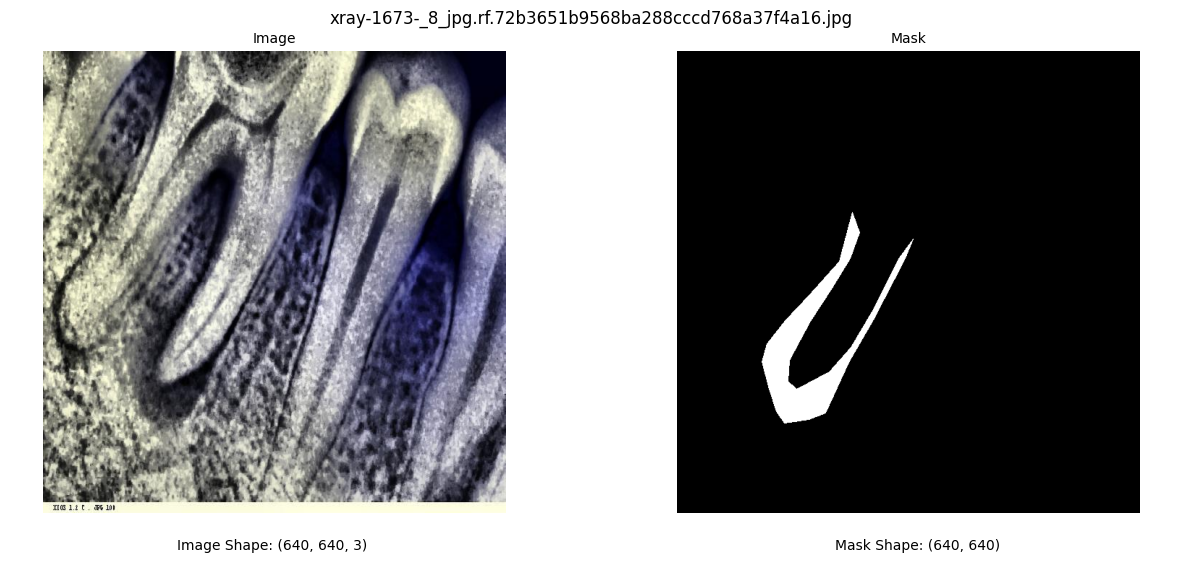

NameError: name 'medsam_model' is not defined

In [36]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline

test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(image)


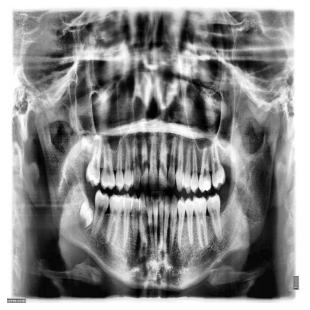

In [ ]:
%matplotlib inline

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:348: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cuda")  # (5, 4)


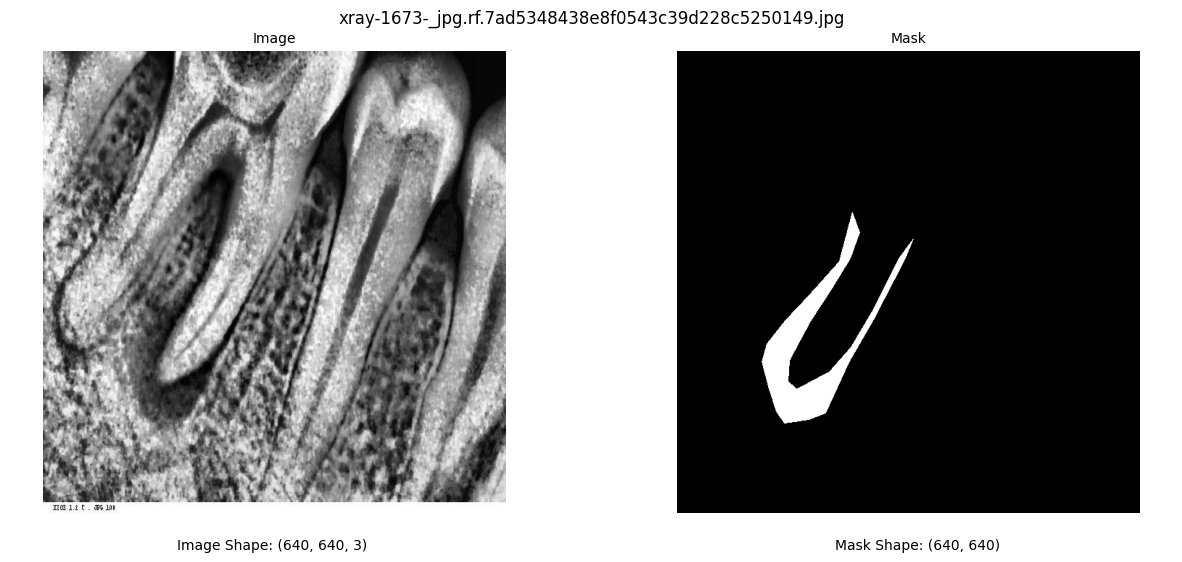

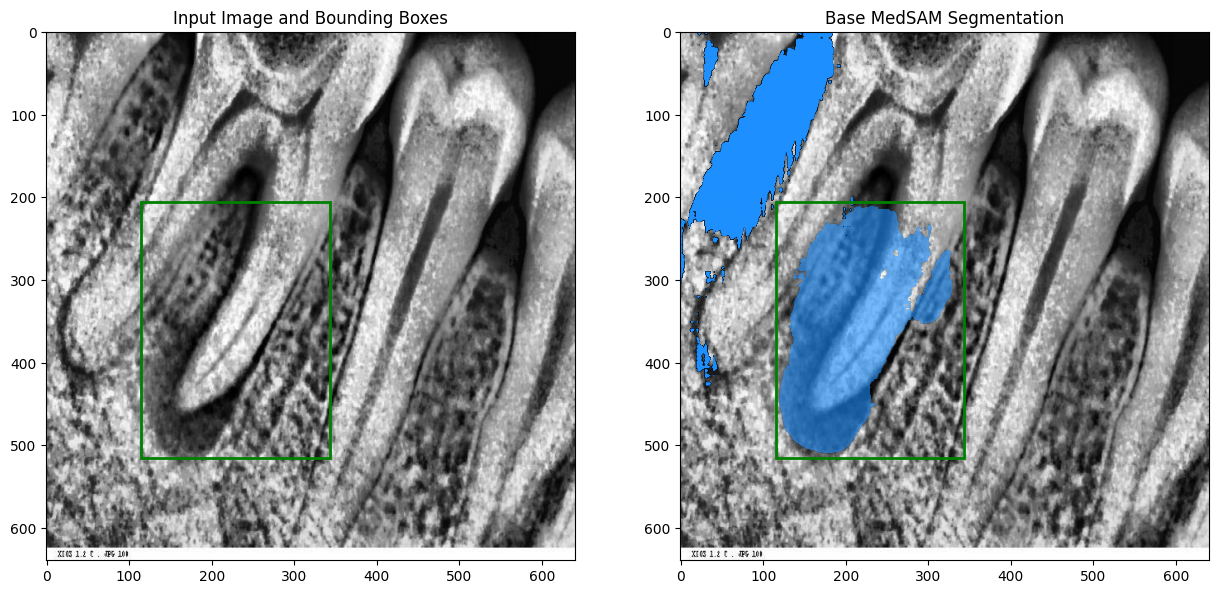

In [ ]:

importlib.reload(model_evaluator)
evaluator = ModelEvaluator(medsam_model, processor, test_dataset)


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True
test_dataset.resize_mask = False

# Load random image
image_idx = random.randint(0, len(test_dataset)-1)


# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape

# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = evaluator.medsam_inference(image_embedding, box_np, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


if len(seg_masks.shape) == 2:
    seg_masks = [seg_masks]


# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1]) # random_colour = True
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

### MedSAM Base Model Evaluation

In [9]:
results = evaluator.evaluate_medsam_model()
evaluator.print_results()

Evaluating MedSAM:   0%|          | 0/82 [00:00<?, ?it/s]d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\model_evaluator.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_mask_tensor = torch.tensor(ground_truth_mask_tensor, dtype=torch.float32).unsqueeze(0).to("cuda")
Evaluating MedSAM:  12%|█▏        | 10/82 [00:27<03:14,  2.70s/it]


KeyboardInterrupt: 

# Set up Dataloaders

### Set and verify dataloaders

d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cpu")  # (5, 4)
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


pixel_values              Shape: torch.Size([3, 1024, 1024])    Dtype: torch.float32
original_sizes            Shape: torch.Size([2])                Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2])                Dtype: torch.int64
input_boxes               Shape: torch.Size([45, 4])            Dtype: torch.float64
obj_ground_truth_masks    Shape: torch.Size([45, 256, 256])     Dtype: torch.float32
ground_truth_mask         Shape: (256, 256)                     Dtype: uint8


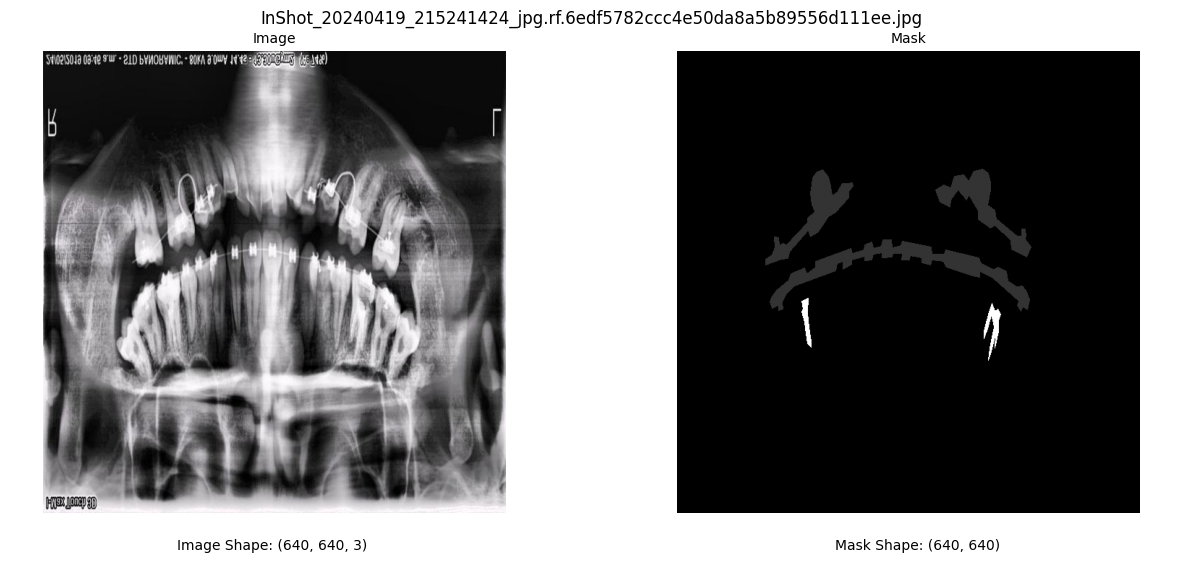

In [5]:
# Ensure images are returned as preprocessed tensors of the right size
test_dataset.preprocess_for_fine_tuning  = True
train_dataset.preprocess_for_fine_tuning = True
valid_dataset.preprocess_for_fine_tuning = True

test_dataset.resize_mask  = True
train_dataset.resize_mask = True
valid_dataset.resize_mask = True

test_dataset.return_individual_objects = True
train_dataset.return_individual_objects = True
valid_dataset.return_individual_objects = True




# Veryify item sizes
example = train_dataset[0]

for k,v in example.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")

train_dataset.show_image_mask(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


pixel_values              Shape: torch.Size([2, 3, 1024, 1024]) Dtype: torch.float32
original_sizes            Shape: torch.Size([2, 2])             Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2, 2])             Dtype: torch.int64
input_boxes               Shape: torch.Size([2, 45, 4])         Dtype: torch.float64
obj_ground_truth_masks    Shape: torch.Size([2, 45, 256, 256])  Dtype: torch.float32
ground_truth_mask         Shape: torch.Size([2, 256, 256])      Dtype: torch.uint8
Image Shape: (1024, 1024, 3)
Ground Truth Shape (256, 256, 1)


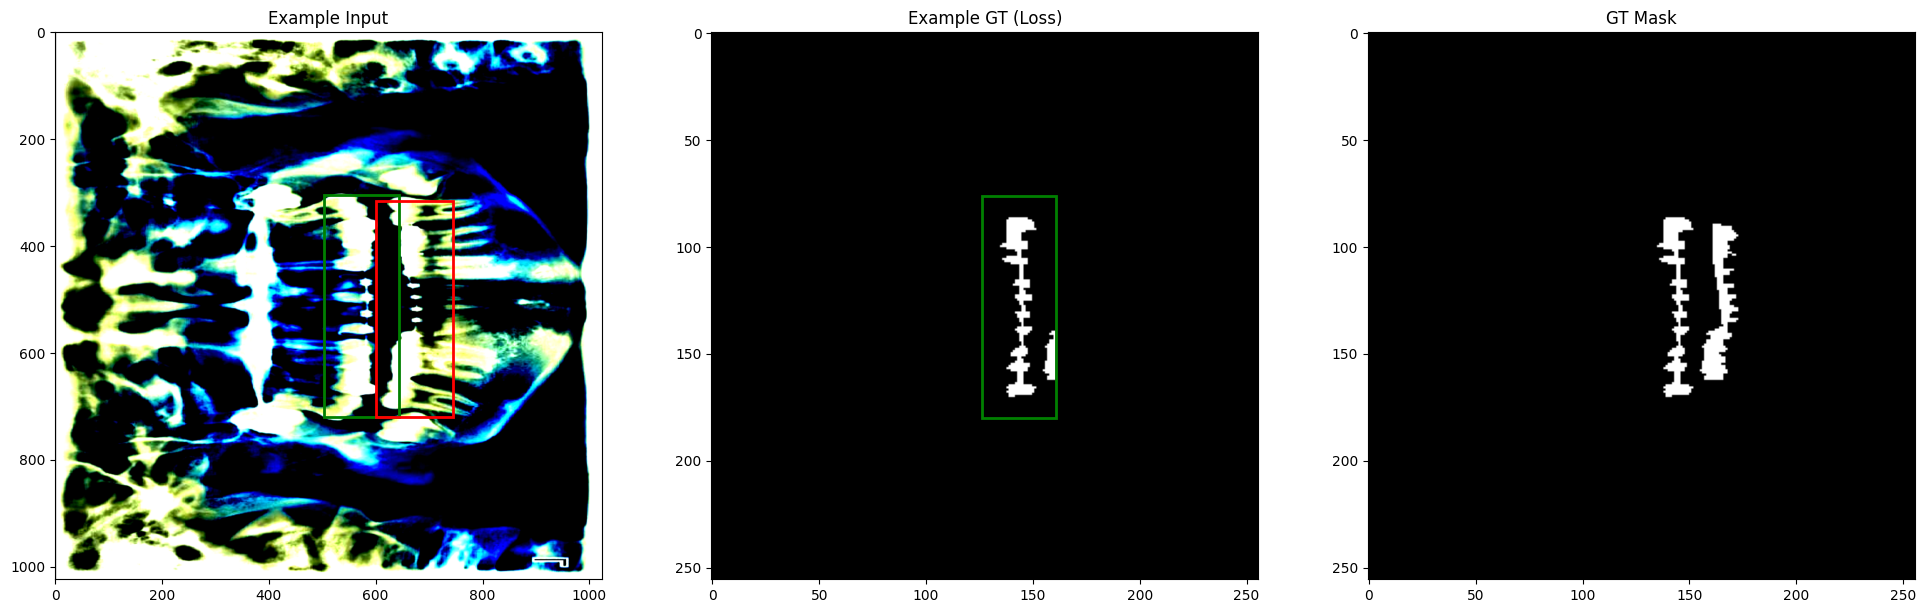

In [31]:
# Set up dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=2  , shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset,  batch_size=1, shuffle=False)




# Verify batch item sizes
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")




# Get image from batch
image = batch["pixel_values"][0].detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC format

# Convert to HxWxC format (just adding a channel dimension if needed)
ground_truth = batch["obj_ground_truth_masks"][0][0].detach().cpu().numpy()  # Convert to numpy (H, W)
ground_truth = np.expand_dims(ground_truth, axis=-1)  # Add a channel dimension (H, W, 1)

print("Image Shape:", image.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24, 8))



ax1.imshow(image)  # Show the image
# Plot predicted boxes
first_box = True
for box in batch["input_boxes"][0]:
    rect = patches.Rectangle(
        (box[0], box[1]),  # x, y (top-left corner)
        box[2] - box[0],  # width
        box[3] - box[1],  # height
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        label='Predicted Box'
    )

    if first_box:
       first_box = False
       rect.set_edgecolor("green")

    ax1.add_patch(rect)
    

ax1.set_title(f"Example Input")





print("Ground Truth Shape", ground_truth.shape)

ax2.imshow(ground_truth, cmap='gray')  # Show the second image
# Plot predicted boxes for the second image
box = batch["input_boxes"][0][0]
box = (box / torch.tensor([1024,1024,1024,1024], device="cpu")) * 256
rect = patches.Rectangle(
    (box[0], box[1]),  # x, y (top-left corner)
    box[2] - box[0],  # width
    box[3] - box[1],  # height
    linewidth=2,
    edgecolor='green',
    facecolor='none',
    label='Predicted Box'
)
    
ax2.add_patch(rect)
ax2.set_title(f"Example GT (Loss)")


ax3.imshow(batch["ground_truth_mask"][0], cmap="gray")
ax3.set_title(f"GT Mask")

plt.show()




# Hyperparameter Tuning (Ray Tune)

### Set Up Remote Actor for Valid Dataloader
 __**NOTE: This cell is where the the outputs from the tuning loop are output**__

In [5]:


# Create a Ray actor to distribute validation data across workers
@ray.remote
class DataLoaderActor:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.iterator = iter(self.dataloader)

    def get_batch(self):
        try:
            return next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.dataloader)  # Reset iterator if exhausted
            return next(self.iterator)

    def get_length(self):
        return len(self.dataloader)



# Wrap the DataLoader inside a Ray actor
valid_dataloader_actor = DataLoaderActor.remote(valid_dataloader)


# Define the custom short directory name function (Avoids window's restriction of paths being < 260 chars)
def short_dirname(trial):
    return "trial_" + str(trial.trial_id[:13])  # Shorten to 8 characters




2025-03-27 13:24:38,456	INFO worker.py:1852 -- Started a local Ray instance.


(DataLoaderActor pid=27100) c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
(DataLoaderActor pid=27100)   warnings.warn(
(DataLoaderActor pid=27100) 2025-03-27 13:24:48.720363: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=26272) c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip 

(<lambda> pid=26272) --- Tuning ---
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240419_215512907_jpg.rf.d24cc7bf25445eee35094e7c688b6ea9.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240419_215723504_jpg.rf.0c38fb8c23ad1b6357b662be98b9ccab.jpg


  0%|          | 0/77 [00:00<?, ?it/s]
(DataLoaderActor pid=27100) d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(DataLoaderActor pid=27100)   box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cpu")  # (5, 4)
(DataLoaderActor pid=27100) c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
(DataLoaderActor pid=27100)   return self.preprocess(images, **kwargs)
  1%|▏         | 1/77 [00:18<24:00, 18.96s/it]


(<lambda> pid=26272) tensor(0.9925, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_135615080_jpg.rf.1bc7691aefef770943b2ad87777ce399.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_135915560_jpg.rf.7d76c0c2b1b66a93d41366f1c7604b20.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_140029896_jpg.rf.89f0e19b892e531a915ceabe8876d451.jpg
(<lambda> pid=26272) tensor(0.9872, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 2/77 [00:38<23:54, 19.13s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_140937270_jpg.rf.01c11df96a3c2cfb145456f178e1c4d5.jpg


  4%|▍         | 3/77 [00:56<23:11, 18.81s/it]


(<lambda> pid=26272) tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_141119277_jpg.rf.de7d118e5f49ab520197ab8c1e1b733a.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_141318204_jpg.rf.23ab36e386feae2fe755cf04c404700f.jpg


  5%|▌         | 4/77 [01:15<22:43, 18.68s/it]


(<lambda> pid=26272) tensor(0.9873, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_141553218_jpg.rf.1ddee9522d469927566cc790abac6f22.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240420_141648175_jpg.rf.18c876245c65adf3f6e6cc2cdb02daa8.jpg


  6%|▋         | 5/77 [01:34<22:40, 18.90s/it]


(<lambda> pid=26272) tensor(0.9792, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_144039373_jpg.rf.37479eed3d9a85f574f674545f15ebd6.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_144712081_jpg.rf.78bbfd7cad2cb25fcca635d95958ad3d.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_144741762_jpg.rf.42ee9628db8776ab2a08f6c0ae3dd039.jpg
(<lambda> pid=26272) tensor(0.9947, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 6/77 [01:52<21:59, 18.58s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_144840255_jpg.rf.9aa006c1967cee33ade568a19e28541c.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_144935300_jpg.rf.30f648f251ffdbd2438edd565511177f.jpg
(<lambda> pid=26272) tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 7/77 [02:09<21:12, 18.18s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_145222079_jpg.rf.0b1578b73a00f93dc33be9be083da69b.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_145247495_jpg.rf.1812ec786af3b496dce14ea5f9730d09.jpg
(<lambda> pid=26272) tensor(0.9956, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 8/77 [02:27<20:37, 17.94s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_145347358_jpg.rf.3dcbb2a7b9c7be8ef441b28669bcadff.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_145610280_jpg.rf.9d8205ad5a4ab1a6852f56723a8cfaf2.jpg
(<lambda> pid=26272) tensor(0.9926, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_145617587_jpg.rf.c5addf6d428e0bed428cf43d7466300c.jpg


 13%|█▎        | 10/77 [03:02<19:46, 17.71s/it]


(<lambda> pid=26272) tensor(0.9937, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_145632298_jpg.rf.09b6ef9e635b911098abd0f95449fd66.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_150028868_jpg.rf.e0334eec4a1132867ae70cbe019917bf.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_150653197_jpg.rf.ce15f1fdee96e86f4c7608e019df4422.jpg
(<lambda> pid=26272) tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_152948417_jpg.rf.8dc304e2593882b7c7d19fddaad500d4.jpg


 16%|█▌        | 12/77 [03:37<19:16, 17.79s/it]


(<lambda> pid=26272) tensor(0.9855, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_152953947_jpg.rf.75169e6a157e9d81367061ba3cdee14b.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_153039120_jpg.rf.87530ac1d2b31b90b766007fbcc84f55.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_153105886_jpg.rf.abdf64ea363146cf250611a967bddf72.jpg
(<lambda> pid=26272) tensor(0.9784, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 13/77 [03:56<19:03, 17.86s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_153223597_jpg.rf.860158c28087cab4611902355f8b8a03.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_153235423_jpg.rf.761fe9034f644013b90d65402692a12b.jpg
(<lambda> pid=26272) tensor(0.9878, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_160138276_jpg.rf.836bfe80f4e90fb30dd208b0d45ec6d5.jpg


 18%|█▊        | 14/77 [04:13<18:38, 17.76s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_160144358_jpg.rf.5e81539773a8503ba6fa13c4343847e5.jpg
(<lambda> pid=26272) tensor(0.9920, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\InShot_20240421_160316269_jpg.rf.2ccc28198dc2a2cac2b886dfe03bc2a2.jpg


 19%|█▉        | 15/77 [04:32<18:43, 18.13s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-20-17-PM_jpeg.rf.73b46b3e82cb792fa234ef60cf9cf2e1.jpg
(<lambda> pid=26272) tensor(0.9923, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 16/77 [04:50<18:17, 18.00s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-20-18-PM_jpeg.rf.c4b2ab78336614f2c0cbe030b74d32b9.jpg


 22%|██▏       | 17/77 [05:08<17:56, 17.95s/it]


(<lambda> pid=26272) tensor(0.9899, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-23-08-PM-2-_jpeg.rf.285dc0ae08bfc09907ac7bffc7e70ee8.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-23-08-PM_jpeg.rf.85cc99a58402c59f9af65a4b8a9ad560.jpg


 23%|██▎       | 18/77 [05:27<18:07, 18.43s/it]


(<lambda> pid=26272) tensor(0.9943, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-23-09-PM-1-_jpeg.rf.a6654c4f53ed61d8099c43c46917e4b7.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-23-09-PM_jpeg.rf.08106c28fd21647bb46b1d5767ae4722.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-26-53-PM-1-_jpeg.rf.f1ffaec98a7f1804b62d17b74ff6d959.jpg
(<lambda> pid=26272) tensor(0.9948, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▍       | 19/77 [05:45<17:31, 18.13s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-26-55-PM-2-_jpeg.rf.e51a5503c8dbafae7ae75ab3056a98ca.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-30-39-PM_jpeg.rf.18f00fa2f32628653eb724de17e4bdec.jpg
(<lambda> pid=26272) tensor(0.9854, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 20/77 [06:02<17:09, 18.06s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-30-40-PM-1-_jpeg.rf.7494fd5add2812048507937ce7cb694d.jpg


 27%|██▋       | 21/77 [06:21<16:56, 18.14s/it]


(<lambda> pid=26272) tensor(0.9894, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-30-41-PM-1-_jpeg.rf.77cfe65fdde06a6bcdd70af3c08cba4b.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-30-41-PM_jpeg.rf.06c73d5d3ea765a409e45cedce0b83d1.jpg


 29%|██▊       | 22/77 [06:39<16:34, 18.08s/it]


(<lambda> pid=26272) tensor(0.9896, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-33-31-PM_jpeg.rf.cd01d3342123dee2d82fc5b25424aa51.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-37-50-PM-1-_jpeg.rf.90ce2976c0e4263d3184f665ffe7dc44.jpg


 30%|██▉       | 23/77 [06:56<15:59, 17.77s/it]


(<lambda> pid=26272) tensor(0.9944, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-42-51-PM-1-_jpeg.rf.28720a4d5e5c3e75e58ea9393703acb2.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-49-05-PM-1-_jpeg.rf.a92bb1dd10f0fc9530d3acf2c519596d.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-49-07-PM_jpeg.rf.779c6bf743093a76facb740cd12d90af.jpg
(<lambda> pid=26272) tensor(0.9975, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 24/77 [07:13<15:33, 17.61s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-53-09-PM_jpeg.rf.1da8f4186de4b75a5bb6fa5bc5f7308b.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\WhatsApp-Image-2024-04-24-at-8-53-11-PM-1-_jpeg.rf.46c971c47cdb217fb76801bab4fa38c7.jpg
(<lambda> pid=26272) tensor(0.9951, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 25/77 [07:31<15:15, 17.60s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1046-_jpg.rf.8cc52a951353801f4e7cf69f4b2407bf.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1054-_jpg.rf.593e3d470f8dcc9c19b588c3da4e015e.jpg
(<lambda> pid=26272) tensor(0.9934, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-106-_jpg.rf.b587483e8c3c942ab44d7b50f5044315.jpg


 34%|███▍      | 26/77 [07:48<14:51, 17.48s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-111-_jpg.rf.ce66ad89648a076d0b845d4febe948d4.jpg
(<lambda> pid=26272) tensor(0.9867, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-118-_jpg.rf.d99cee79cba70aa58a565edd69822cc7.jpg


 35%|███▌      | 27/77 [08:05<14:30, 17.41s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-145-_jpg.rf.bf394e2aeaba8c047dd8c364943454c4.jpg
(<lambda> pid=26272) tensor(0.9958, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-151-_jpg.rf.4b87cd415cf558702248ae66eea9e623.jpg


 36%|███▋      | 28/77 [08:22<14:11, 17.38s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-152-_jpg.rf.204130c7e71b1ef5771bec8278e085b4.jpg
(<lambda> pid=26272) tensor(0.9970, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-154-_jpg.rf.441c36c76a163ce1f6d21d00a95abcdd.jpg


 39%|███▉      | 30/77 [08:58<13:45, 17.57s/it]


(<lambda> pid=26272) tensor(0.9993, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1541-_1_jpg.rf.b13caca1e476f9bed7a07dd5c11ca1b3.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1541-_2_jpg.rf.21a35c8f9360fccf509e0995e22c0b34.jpg


 40%|████      | 31/77 [09:15<13:21, 17.41s/it]


(<lambda> pid=26272) tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1541-_3_jpg.rf.26f78e142fc9efaa0233b7ebc35a791a.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1544-_10_jpg.rf.3af27883e902f74f75d0eedc64552cd3.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1544-_7_jpg.rf.9cedd00050270730fcb88af1e631c6f9.jpg
(<lambda> pid=26272) tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1544-_9_jpg.rf.aeec736e2c325799f6a274d188c0d423.jpg


 42%|████▏     | 32/77 [09:32<12:58, 17.29s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1544-_jpg.rf.05b4a89777ee7e981ed83c1bc68c7066.jpg
(<lambda> pid=26272) tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 33/77 [09:50<12:47, 17.43s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1548-_10_jpg.rf.e02b65e5f99e4c256e4ab0924903d0bc.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1548-_3_jpg.rf.51658debf46f5d4140953244f6db48db.jpg
(<lambda> pid=26272) tensor(0.9910, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 34/77 [10:07<12:31, 17.47s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1548-_4_jpg.rf.e7543a4c75e7f13606ddb891dfeebed7.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1548-_7_jpg.rf.ca34865a98d0de67668fadb93e456136.jpg
(<lambda> pid=26272) tensor(0.9871, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1611-_7_jpg.rf.70d6853c3f16a10970f3dc3e0d74e082.jpg


 45%|████▌     | 35/77 [10:25<12:16, 17.55s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-165-_jpg.rf.96d4a9c28407169fe5c6efb31fdbe6bf.jpg
(<lambda> pid=26272) tensor(0.9791, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 36/77 [10:43<12:04, 17.67s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-166-_jpg.rf.e6db1f4eb057175c08de55e286a44b1d.jpg


 48%|████▊     | 37/77 [11:00<11:41, 17.53s/it]


(<lambda> pid=26272) tensor(0.9985, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1673-_1_jpg.rf.c877a475fcc7fa5d7692d921631d7e38.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-170-_jpg.rf.5e5e21c269dd5dc01e608f10f822e35c.jpg


 49%|████▉     | 38/77 [11:17<11:18, 17.40s/it]


(<lambda> pid=26272) tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-181-_jpg.rf.28bd5a1c501da2600298c6a79878e701.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-183-_jpg.rf.273b2ee46e365af832a9b89b69cde2bd.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-186-_jpg.rf.008a6724e8538621d75c0bae23fca931.jpg
(<lambda> pid=26272) tensor(0.9960, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 39/77 [11:35<11:03, 17.45s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1966-_10_jpg.rf.72ec887f340b295b4c0fc2a48e4abd2f.jpg


 52%|█████▏    | 40/77 [11:54<11:00, 17.86s/it]


(<lambda> pid=26272) tensor(0.9957, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-1966-_5_jpg.rf.1903fc97838ca6523a284a4896899355.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-199-_jpg.rf.52256697e8f4df04664ebd5040ceeb1f.jpg


 53%|█████▎    | 41/77 [12:12<10:50, 18.08s/it]


(<lambda> pid=26272) tensor(0.9901, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-205-_jpg.rf.d01e5ceed2b4eac1b5e7fe1df764c65f.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2052-_2_jpg.rf.3c0f04f7c19beb2152818058d4974546.jpg


 55%|█████▍    | 42/77 [12:31<10:40, 18.30s/it]


(<lambda> pid=26272) tensor(0.9888, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2052-_7_jpg.rf.4df819998ae2e7ffcd3e996e59592726.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2052-_8_jpg.rf.9d53ba361d83e4021ebcc41417f46423.jpg


 56%|█████▌    | 43/77 [12:48<10:11, 17.98s/it]


(<lambda> pid=26272) tensor(0.9936, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-207-_jpg.rf.578316c3e6856c5fc0fa5f528fda379c.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2117-_10_jpg.rf.d6d18d35245d95ff7fd9ab766acae54c.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2117-_6_jpg.rf.c356a7c628daaeb044ab2be93a051a84.jpg
(<lambda> pid=26272) tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2117-_jpg.rf.e328e3c04d1fd04734f8c0246f16e679.jpg


 58%|█████▊    | 45/77 [13:23<09:22, 17.58s/it]


(<lambda> pid=26272) tensor(0.9955, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-224-_jpg.rf.bf15278a2399195d2e9a1460941e229a.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2262-_jpg.rf.e3e4a6a488883c992e6ea5f730ec4fca.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-229-_jpg.rf.41c60dd9e7870933e357d727eb7ecff6.jpg
(<lambda> pid=26272) tensor(0.9945, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|█████▉    | 46/77 [13:40<09:01, 17.45s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2345-_4_jpg.rf.99fdb66df70a484b62afcaf385e5c01f.jpg


 61%|██████    | 47/77 [13:57<08:43, 17.46s/it]


(<lambda> pid=26272) tensor(0.9898, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2345-_5_jpg.rf.780b3c07c412909f9e33c8c69d494202.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2345-_6_jpg.rf.092e0e6b4826eeb7acba1f2face37238.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2345-_9_jpg.rf.12e99370385d5db82c7dd4d7e625430d.jpg
(<lambda> pid=26272) tensor(0.9952, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 48/77 [14:19<09:00, 18.63s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-2345-_jpg.rf.7872d640b5ad3c89aaceebde6015ff9e.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-251-_jpg.rf.0cacde69bcee10ba38474f35d362633f.jpg
(<lambda> pid=26272) tensor(0.9953, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▎   | 49/77 [14:39<08:52, 19.03s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-253-_jpg.rf.4cf246d289b62021375bb3ee406b807f.jpg


 65%|██████▍   | 50/77 [14:59<08:39, 19.24s/it]


(<lambda> pid=26272) tensor(0.9902, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-280-_jpg.rf.0589fb17d1a7b6b7f417d2f1d70b02c3.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-290-_jpg.rf.15a4a238bd8259f9b08bd74cbe05ddef.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-313-_jpg.rf.3609cda7d2aad1b339efc0c71038b9a7.jpg
(<lambda> pid=26272) tensor(0.9859, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-323-_jpg.rf.a9f79d80bb7cd54cd76d19ca9241df31.jpg


 66%|██████▌   | 51/77 [15:23<09:01, 20.83s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-330-_jpg.rf.236d4ee0ad2691f244651bc1f7bc764b.jpg
(<lambda> pid=26272) tensor(0.9980, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 52/77 [15:42<08:29, 20.38s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-337-_jpg.rf.ebb3f2eabbb148af4ccc5cdaa7e5c395.jpg


 69%|██████▉   | 53/77 [16:02<08:04, 20.19s/it]


(<lambda> pid=26272) tensor(0.9883, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-339-_jpg.rf.d90c4e989ed57dc611b1d61b782a54c3.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-346-_jpg.rf.352bd8ae12d9670d01843c4668705a4b.jpg


 70%|███████   | 54/77 [16:24<07:54, 20.65s/it]


(<lambda> pid=26272) tensor(0.9935, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-364-_jpg.rf.d9adfdd03e18799184624f55d6eb19ec.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-375-_jpg.rf.003524b3c514d284a331bc969ea3bff2.jpg


 71%|███████▏  | 55/77 [16:50<08:10, 22.28s/it]


(<lambda> pid=26272) tensor(0.9915, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-377-_jpg.rf.59e3f158cdb9431ab65600e9daeb66d7.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-397-_jpg.rf.e27482a08aa51a3e2a9d3fb0c835073b.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-401-_jpg.rf.c0aae76cc21bd16fa6af36a1c1b3d6b0.jpg
(<lambda> pid=26272) tensor(0.9838, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-406-_jpg.rf.fa8a52625278072b89e321186e67ac38.jpg


 73%|███████▎  | 56/77 [17:10<07:35, 21.68s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-407-_jpg.rf.2979b1921ed332dadd2933b4458ea364.jpg
(<lambda> pid=26272) tensor(0.9950, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 57/77 [17:30<07:04, 21.21s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-430-_jpg.rf.3606f713d8def7141b13a9b42522765d.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-501-_jpg.rf.26bbad12c46edc62349671e5b3549170.jpg
(<lambda> pid=26272) tensor(0.9914, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 58/77 [17:56<07:07, 22.53s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-504-_jpg.rf.b772b12a384b9bcdd84601a77e108178.jpg


 77%|███████▋  | 59/77 [18:21<06:57, 23.18s/it]


(<lambda> pid=26272) tensor(0.9979, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-507-_jpg.rf.b039b1e4fb4de76dd4b300bf7257bc8b.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-511-_jpg.rf.bdeacc29ae840dc3fb73cac009317010.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-530-_jpg.rf.66a6cb72d82408818e6199f4c3593520.jpg
(<lambda> pid=26272) tensor(0.9942, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-540-_jpg.rf.01a61481f8f901323628e045b8993e4e.jpg


 78%|███████▊  | 60/77 [18:40<06:12, 21.92s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-541-_jpg.rf.81457b04163f63066235ccaa33709ddf.jpg
(<lambda> pid=26272) tensor(0.9966, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 61/77 [18:58<05:33, 20.82s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-559-_jpg.rf.716c7d325f348ca1d5b3674ddece7aee.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-567-_jpg.rf.ac062d55973d167dad17e0eee9ba0450.jpg
(<lambda> pid=26272) tensor(0.9949, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 62/77 [19:16<04:59, 19.99s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-569-_jpg.rf.60c0a9e36f2b29c51a36de6dd3b3827c.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-571-_jpg.rf.f8538d18312fdbcd8e9612220eb4af48.jpg
(<lambda> pid=26272) tensor(0.9895, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 63/77 [19:34<04:33, 19.52s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-575-_jpg.rf.c01dd81bf4c9697d0ff8fed00bd1de75.jpg


 83%|████████▎ | 64/77 [19:52<04:06, 18.95s/it]


(<lambda> pid=26272) tensor(0.9994, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-584-_jpg.rf.14f6c862eed554b6d2e4bde5760c7724.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-585-_jpg.rf.2b3cc8cd9f7df6269a5a57993fc1e6e6.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-599-_jpg.rf.0c0fa37db4ff3d37a300100c78a06336.jpg
(<lambda> pid=26272) tensor(0.9973, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-654-_jpg.rf.ef8d947156256aba000cb70f00072398.jpg


 86%|████████▌ | 66/77 [20:27<03:21, 18.32s/it]


(<lambda> pid=26272) tensor(0.9977, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-678-_jpg.rf.fb535da707f0b8d2b065bb19b789133d.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-683-_jpg.rf.03cc973d8d162c5dad287bc1b820549e.jpg


 87%|████████▋ | 67/77 [20:45<03:01, 18.17s/it]


(<lambda> pid=26272) tensor(0.9978, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-691-_jpg.rf.ea1268902d6d42dd1865fdaba39ae448.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-694-_jpg.rf.ffdc03aabb7b220dd7f5bc3a585ca0b1.jpg


 88%|████████▊ | 68/77 [21:04<02:45, 18.38s/it]


(<lambda> pid=26272) tensor(0.9968, device='cuda:0', grad_fn=<MeanBackward0>)
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-707-_jpg.rf.0995cb82487a8f5606fd2fcf898ee539.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-708-_jpg.rf.e9c04fe089570e2e3a609c45babbe1bc.jpg
(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-716-_jpg.rf.15d7326895937b06965e115ea57ecc19.jpg
(<lambda> pid=26272) tensor(0.9984, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|████████▉ | 69/77 [21:23<02:28, 18.52s/it]


(DataLoaderActor pid=27100) Image Retrived: Datasets/Dental project.v19i.coco-1\valid\xray-745-_jpg.rf.6c19711213acadf91e90942dd1a15e26.jpg


 90%|████████▉ | 69/77 [21:26<02:29, 18.65s/it]


### Tuning The Optimisers

In [13]:
# Function to train and evaluate model with different optimizer settings
def tune_optimizer(config, dataloader_actor):
    # Clear CUDA memory at the start of each call
    torch.cuda.empty_cache()

    # Initialize model
    medsam_model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

    # Freeze encoder layers
    for name, param in medsam_model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)
    
    medsam_model.to("cuda")

    # Define optimizer based on config
    if config["optimizer"] == "adam":
        optimizer = Adam(
            params=medsam_model.mask_decoder.parameters(),
            lr=config["lr"],      
            weight_decay=config["weight_decay"]   
        )
    elif config["optimizer"] == "sgd":
        optimizer = SGD(
            params=medsam_model.mask_decoder.parameters(),
            lr=config["lr"],
            momentum=config["momentum"],
            weight_decay=config["weight_decay"]
        )

    # Use Focal Loss with predefined sensible parameters
    loss_fn = monai.losses.FocalLoss(
        gamma=2.0,  # Common default for Focal Loss
        reduction="mean",
        include_background=True
    )

    # Train for one epoch with the current configuration
    epoch_losses = []
    for _ in tqdm(range(ray.get(dataloader_actor.get_length.remote()))):
        batch = ray.get(dataloader_actor.get_batch.remote())  # Fetch batch using Ray actor

        # forward pass
        outputs = medsam_model(
            pixel_values=batch["pixel_values"].to("cuda"),
            input_boxes=batch["input_boxes"].to("cuda"),
            multimask_output=False
        )

        # Get predicted masks and ground truth masks
        predicted_masks = outputs.pred_masks.squeeze(2)
        obj_ground_truth_masks = batch["obj_ground_truth_masks"].float().to("cuda").squeeze(1)

        # Convert object ground truth masks to binary to pass into loss function
        obj_ground_truth_masks = (obj_ground_truth_masks > 0).float()

        # Convert logits to probabilities
        predicted_masks = torch.sigmoid(predicted_masks)

        # Calculate loss using Focal Loss
        loss = loss_fn(predicted_masks, obj_ground_truth_masks)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Compute and report mean loss for the epoch
    mean_epoch_loss = mean(epoch_losses)
    tune.report(loss=mean_epoch_loss)


In [14]:

# Define the search space for optimizer tuning
search_space_optimiser = {
    "optimizer": tune.choice(["adam", "sgd"]),
    "lr": tune.loguniform(1e-5, 1e-3), 
    "weight_decay": tune.uniform(0, 1e-3), 
    "momentum": tune.uniform(0, 0.99),  # SGD-specific momentum
}

# Get the absolute path for 'ray_results'
storage_path = os.path.abspath("Ray Results/Optimizer")

# Run Ray Tune with the absolute path
result = tune.run(
    lambda config: tune_optimizer(config, valid_dataloader_actor),  # Lambda function to pass dataloader_actor
    config=search_space_optimiser,  # The search space
    num_samples=10,  # Number of trials to run
    trial_dirname_creator=short_dirname,  # Custom trial log directory name
    resources_per_trial={"gpu": 1},  # Ensure 1 GPU per trial
    storage_path=storage_path  # Use the absolute path for storage
)

2025-03-27 12:49:30,387	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-27 12:52:25,873	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-03-27 12:52:25,886	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/Documents/Uni Work/Automated Dental Segmentation/Automated-Dental-Segmentation/Ray Results/Optimizer/lambda_2025-03-27_12-49-30' in 0.0100s.
2025-03-27 12:52:36,052	INFO tune.py:1041 -- Total run time: 185.67 seconds (175.47 seconds for the tuning loop).
2025-03-27 12:52:36,054	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-03-27 12:52:36,328	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 9 trial(s):
- lambda_eccdf_00001: FileNotFoundError('Could not fetch metrics for lambda_eccdf_00001: both result.json and progress.cs

In [ ]:
# Get best loss function and parameters
best_optimiser_config = results.get_best_result(metric="optimiser", mode="min").config
print("Best Optimiser Config:", best_optimiser_config)

### Tuning The Loss Funtions


In [ ]:

# Function to train and evaluate model with different loss function settings
def tune_loss(config, dataloader_actor):

    print("--- Tuning ---")

    # Clear CUDA memory at the start of each call
    torch.cuda.empty_cache()

    # Initialize model
    medsam_model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

    # Freeze encoder layers
    for name, param in medsam_model.named_parameters():
        if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
            param.requires_grad_(False)
    
    medsam_model.to("cuda")

    # Baseline Optimizer
    optimizer = Adam(
        params=medsam_model.mask_decoder.parameters(),
        lr=0.0001,      
        weight_decay=0   
    )

    # Choose loss functions
    if config["loss"] == "dice":
        loss_fn = monai.losses.DiceLoss(
            squared_pred=config["squared_pred"],
            reduction="mean",
            include_background=config["include_background"]
        )
    elif config["loss"] == "focal":
        loss_fn = monai.losses.FocalLoss(
            gamma=config["gamma"],
            reduction="mean",
            include_background=config["include_background"]
        )
    elif config["loss"] == "tversky":
        loss_fn = monai.losses.TverskyLoss(
            alpha=config["alpha"],
            beta=config["beta"],
            reduction="mean",
            include_background=config["include_background"]
        )

    # Train for one epoch with the current configuration
    epoch_losses = []
    for _ in tqdm(range(ray.get(dataloader_actor.get_length.remote()))):
        batch = ray.get(dataloader_actor.get_batch.remote())  # Fetch batch using Ray actor

        # forward pass
        outputs = medsam_model(
            pixel_values=batch["pixel_values"].to("cuda"),
            input_boxes=batch["input_boxes"].to("cuda"),
            multimask_output=False
        )

        # Get predicted masks and ground truth masks
        predicted_masks = outputs.pred_masks.squeeze(2)
        obj_ground_truth_masks = batch["obj_ground_truth_masks"].float().to("cuda").squeeze(1)

        # Convert object ground truth masks to binary to pass into loss function
        obj_ground_truth_masks = (obj_ground_truth_masks > 0).float()

        # Convert logits to probabilities
        predicted_masks = torch.sigmoid(predicted_masks)

        # Calculate loss using defined loss function and params
        loss = loss_fn(predicted_masks, obj_ground_truth_masks)


        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        print(loss)


    # Compute and report mean loss for the epoch
    mean_epoch_loss = mean(epoch_losses)
    tune.report(loss=mean_epoch_loss)


In [7]:

# Define the search space for loss function tuning
search_space_loss = {
    "loss":               tune.choice(["dice", "focal", "tversky"]),
    "include_background": tune.choice([False]),    # Maybe add true, but I think its too imbalanced to use (binary imbalance)
    "squared_pred":       tune.choice([True, False]),  # Only for Dice loss
    "gamma":              tune.uniform(1.0, 5.0),  # Only for Focal loss (A higher value of gamma can be better for imbalanced classes (e.g. 3-5))
    "alpha":              tune.uniform(0.3, 0.7),  # Only for Tversky loss (false positives)
    "beta":               tune.uniform(0.3, 0.8)    # Only for Tversky loss (false negatives)
}


# Get the absolute path for 'ray_results'
storage_path = os.path.abspath("Ray Results/Loss")

# Run Ray Tune with the absolute path
result = tune.run(
    lambda config: tune_loss(config, valid_dataloader_actor),  # Lambda function to pass dataloader_actor
    config=search_space_loss,  # The search space
    num_samples=1,  # Number of trials to run
    trial_dirname_creator=short_dirname,  # Custom trial log directory name
    resources_per_trial={"cpu": 8, "gpu": 1},  # Ensure 1 GPU per trial
    storage_path=storage_path  # Use the absolute path for storage
)


2025-03-27 13:24:41,317	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-03-27 13:46:27,938	ERROR tune_controller.py:1331 -- Trial task failed for trial lambda_d708e_00000
Traceback (most recent call last):
  File "c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\ray\_private\worker.py", line 2782, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\ray\_private\worker.py", line 929, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTa

Trial name
lambda_d708e_00000


2025-03-27 13:46:28,257	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'd:/Documents/Uni Work/Automated Dental Segmentation/Automated-Dental-Segmentation/Ray Results/Loss/lambda_2025-03-27_13-24-41' in 0.0389s.


TuneError: ('Trials did not complete', [lambda_d708e_00000])

In [ ]:
# Get best loss function and parameters
best_loss_config = results.get_best_result(metric="loss", mode="min").config
print("Best Loss Config:", best_loss_config)

# Fine-tuning MedSAM

## Fine-Tuning Hugging Face SamProcessor (MedSAM)

In [7]:
# Remove previous models from memory
medsam_model = None
del medsam_model
torch.cuda.empty_cache()

# load the pretrained weights for finetuning
medsam_model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in medsam_model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

  
device = "cuda"
medsam_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [8]:


# Set optimisers (These will be used for hyperparameter tuning later)

# Initialize the optimizer and the loss function (May need to play with lower learning rates to avoid changing base model too much)
adam_optimizer = Adam(medsam_model.mask_decoder.parameters(), lr=0.00001, weight_decay=0)

sgd_optimizer  = SGD(medsam_model.mask_decoder.parameters(), lr=0.01, momentum=0.9)



# Set loss functions

# Define the DiceCELoss
dice_loss = monai.losses.DiceLoss(
    squared_pred=True,       # square predictions for  dice calculation (peanalises false positives)
    reduction='mean',        # how losses are aggregated (mean, sum, or none)
    include_background = False
)


# Define the Focal Loss (good for imbalanced pixel coverage)
focal_loss = monai.losses.FocalLoss(
    gamma=2.0,             # Focusing (higher = more focus on hard examples)
    reduction='mean',       # How losses are aggregated (mean, sum, or none)
    include_background = False
)


# Define Tversky Loss (false pos not that imporant, but false neg is bad)
tversky_loss = monai.losses.TverskyLoss(
    alpha=0.7,              # increase for less false positives
    beta=0.3,               # increase for less false negatives
    reduction='mean',       # how losses are aggregated (mean, sum, or none)
    include_background = False
)


# Maybe also try focal or dicefocal loss?


### Base Training Loop

In [9]:

def remove_and_pad_invalid_boxes(input_boxes, obj_ground_truth_masks):

    # Create a mask to identify input_boxes that are [0,0,0,0]
    valid_mask = (input_boxes != torch.tensor([0, 0, 0, 0], dtype=torch.float64, device="cuda")).all(dim=-1)

    # Filter input boxes and corresponding masks for each image in the batch
    filtered_input_boxes = [input_boxes[i][valid_mask[i]] for i in range(input_boxes.shape[0])]
    filtered_obj_ground_truth_masks = [obj_ground_truth_masks[i][valid_mask[i]] for i in range(input_boxes.shape[0])]

    # Convert filtered lists back to tensors and pad them
    padded_input_boxes = torch.nn.utils.rnn.pad_sequence(filtered_input_boxes, batch_first=True, padding_value=0)
    padded_obj_ground_truth_masks = torch.nn.utils.rnn.pad_sequence(filtered_obj_ground_truth_masks, batch_first=True, padding_value=0)

    return padded_input_boxes, padded_obj_ground_truth_masks

In [14]:
def remove_invalid_boxes(input_boxes, obj_ground_truth_masks):
    # Create a mask to identify input_boxes that are [0,0,0,0]
    valid_mask = (input_boxes != torch.tensor([0, 0, 0, 0], dtype=torch.float64, device=input_boxes.device)).all(dim=-1)

    # Filter input boxes and corresponding masks for each image in the batch (batch size = 1)
    filtered_input_boxes = input_boxes[valid_mask]
    filtered_obj_ground_truth_masks = obj_ground_truth_masks[valid_mask]

    # Return filtered input boxes and ground truth masks, maintaining batch size of 1
    return filtered_input_boxes.unsqueeze(0), filtered_obj_ground_truth_masks.unsqueeze(0)



In [ ]:
torch.cuda.empty_cache()

#Training loop
num_epochs = 1
batch_losses = []  # Store loss for each batch

medsam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        # print(batch.keys())


        # Get batch values for inference
        pixel_values = batch["pixel_values"].to(device)
        input_boxes = batch["input_boxes"].to(device)
        obj_ground_truth_masks = batch["obj_ground_truth_masks"].float().to(device).squeeze(1)  # Remove extra singleton dimension



        # To ge the mean of each individual image in the batch
        batch_loss_values = []


        # Loops through each image in the batch, removes the padding on input_boxes and obj_ground_truth_masks to ensure the loss isn't miscalculated by using empty inputs (because that happens??)
        # We take the mean of the batch still (using batch_loss_values) to ensure a smoother gradient by avoiding the noise from using individual images
        for image, input_box, obj_mask in zip(pixel_values, input_boxes, obj_ground_truth_masks):

            # Remove the padding from these batch values
            input_box, obj_mask = remove_invalid_boxes(input_box, obj_mask)


            # If the input somehow has no object masks we can skip
            if input_box.shape[1] > 0:

                # forward pass
                outputs = medsam_model(
                    pixel_values=image.unsqueeze(0), # Add batch dimension back
                    input_boxes=input_box,
                    multimask_output=False)


                # Get predicted masks and ground truth masks
                predicted_masks = outputs.pred_masks.squeeze(2)  # Remove extra singleton dimension from predicted masks (shape: [1, 20, 256, 256])
            
                # Convert object ground truth masks to binary to pass into MONAI loss function
                obj_mask = (obj_mask > 0).float()

                # Ensure the predicted and ground truth masks have the same shape
                #print("\n\nPredicted Mask shape: ",predicted_masks.shape)
                #print("obj gt shape: ", obj_mask.shape)

                # Convert logits to probabilities
                predicted_masks = torch.sigmoid(predicted_masks) 

                # Calculate loss using defined loss function
                batch_loss_values.append(dice_loss(predicted_masks, obj_mask))
                print("Object Loss: ",batch_loss_values[-1])



            else:
                # Debug print to catch the missing masks
                print(input_box)




        # Calculate the mean of the batch and convert into a torch tensor for backpropagation
        loss = torch.stack(batch_loss_values).mean() if batch_loss_values else torch.tensor(0.0)
        print("Batch Loss: ", loss)

        # backward pass
        adam_optimizer.zero_grad()
        loss.backward()

        # optimize
        adam_optimizer.step()
        epoch_losses.append(loss.item())

        # Store batch loss
        batch_losses.append(loss.item())





        # NOTE: sigmoid and softmax have the same output range here indicating that the SAM and MedSAM models only predict one class by default. This might 
        # Calculate the max and min values for both predicted and ground truth masks
        # pred_min_value = F.softmax(predicted_masks).min().item()
        # pred_max_value = F.softmax(predicted_masks).max().item()
        # gt_min_value = obj_ground_truth_masks.min().item()
        # gt_max_value = obj_ground_truth_masks.max().item()

        # Print the min and max values for both predicted and ground truth masks
        #print(f"Predicted Mask - Min Value: {pred_min_value}, Max Value: {pred_max_value}")
        #print(f"Ground Truth Mask - Min Value: {gt_min_value}, Max Value: {gt_max_value}")
        
        



        # Show predictions
        # with torch.no_grad():
        #         first_pred_mask = torch.sigmoid(predicted_masks[0, 0]).cpu().numpy()  # Convert to numpy for plotting
        #         first_gt_mask = obj_ground_truth_masks[0, 0].cpu().numpy()

        #         fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        #         ax[0].imshow(first_pred_mask, cmap="gray")
        #         ax[0].set_title("Predicted Mask")

        #         ax[1].imshow(first_gt_mask, cmap="gray")
        #         ax[1].set_title("Ground Truth Mask")

        #         plt.show()





    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     

# Save the model's state dictionary to a file
torch.save(medsam_model.state_dict(), "Models/medsam_vit_b_object_masks.pth")
     


  0%|          | 0/850 [00:00<?, ?it/s]

First:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 13, 4]) torch.Size([1, 13, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 13, 256, 256])
obj gt shape:  torch.Size([1, 13, 256, 256])
Object Loss:  tensor(0.6244, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 8, 4]) torch.Size([1, 8, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 8, 256, 256])
obj gt shape:  torch.Size([1, 8, 256, 256])
Object Loss:  tensor(0.7230, device='cuda:0', grad_fn=<MeanBackward0>)
Batch Loss:  tensor(0.6737, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/850 [00:09<2:20:37,  9.94s/it]

First:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 13, 4]) torch.Size([1, 13, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 13, 256, 256])
obj gt shape:  torch.Size([1, 13, 256, 256])
Object Loss:  tensor(0.5667, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 6, 4]) torch.Size([1, 6, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 6, 256, 256])
obj gt shape:  torch.Size([1, 6, 256, 256])
Object Loss:  tensor(0.6739, device='cuda:0', grad_fn=<MeanBackward0>)
Batch Loss:  tensor(0.6203, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/850 [00:18<2:11:12,  9.28s/it]

First:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 3, 4]) torch.Size([1, 3, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 3, 256, 256])
obj gt shape:  torch.Size([1, 3, 256, 256])
Object Loss:  tensor(0.2943, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 5, 4]) torch.Size([1, 5, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 5, 256, 256])
obj gt shape:  torch.Size([1, 5, 256, 256])
Object Loss:  tensor(0.6649, device='cuda:0', grad_fn=<MeanBackward0>)
Batch Loss:  tensor(0.4796, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/850 [00:24<1:45:56,  7.50s/it]

First:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 1, 4]) torch.Size([1, 1, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


Predicted Mask shape:  torch.Size([1, 1, 256, 256])
obj gt shape:  torch.Size([1, 1, 256, 256])
Object Loss:  tensor(0.1959, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([45, 4]) torch.Size([45, 256, 256])
After:  torch.Size([1, 2, 4]) torch.Size([1, 2, 256, 256])
last:  torch.Size([2, 45, 4]) torch.Size([2, 45, 256, 256])


  0%|          | 4/850 [00:30<1:37:07,  6.89s/it]



Predicted Mask shape:  torch.Size([1, 2, 256, 256])
obj gt shape:  torch.Size([1, 2, 256, 256])
Object Loss:  tensor(0.2291, device='cuda:0', grad_fn=<MeanBackward0>)
Batch Loss:  tensor(0.2125, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/850 [00:30<1:48:16,  7.68s/it]


KeyboardInterrupt: 

### Weighted Loss Training Loop (Do not use while undersampling!)

In [10]:

# To define class weights I have used the average pixel frequency * class freq in an inverse ratio to the total. 
# I have capped the background as it has significantly more pixels than any object, and fillings as they were too common.

# Define Class Weights
class_weights = torch.tensor([
    0.02,   # Background
    0.133,  # braces
    0.184,  # bridge
    0.086,  # cavity
    0.081,  # crown
    0.05,   # filling
    0.326,  # implant
    0.172   # lesion 
    ]).to(device)  


# Define the DiceCELoss
dice_loss = monai.losses.DiceLoss(
    sigmoid=True,            # sigmoid activation
    squared_pred=True,       # square predictions for  dice calculation (peanalises false positives)
    reduction="none",        # how losses are aggregated (mean, sum, or none)
    include_background = False
)


# Define the Focal Loss (good for imbalanced pixel coverage)
focal_loss = monai.losses.FocalLoss(
    gamma=2.0,             # Focusing (higher = more focus on hard examples)
    reduction="none",      # How losses are aggregated (mean, sum, or none)
    include_background = False
)

# Define Tversky Loss (false pos not that imporant, but false neg is bad)
tversky_loss = monai.losses.TverskyLoss(
    alpha=0.7,              # increase for less false positives
    beta=0.3,               # increase for less false negatives
    reduction="none",       # how losses are aggregated (mean, sum, or none)
    include_background = False
)


# Maybe also try focal or dicefocal loss?


In [15]:

#Training loop
num_epochs = 1
batch_losses = []  # Store loss for each batch

medsam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        

        # print(batch.keys())
      
        

        # forward pass
        outputs = medsam_model(pixel_values=batch["pixel_values"].to(device),
                        #input_masks=batch["labels"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

       

        # Get predicted masks, object ground truth masks and whole image ground truth mask
        predicted_masks = outputs.pred_masks.squeeze(2)  # Remove extra singleton dimension from predicted masks (shape: [2, 20, 256, 256])
        obj_ground_truth_masks = batch["obj_ground_truth_masks"].float().to(device).squeeze(1)  # Remove extra singleton dimension from ground truth (shape: [2, 20, 256, 256])



        ground_truth_mask = batch["ground_truth_mask"]

        # Ensure the predicted and ground truth masks have the same shape
        # print(predicted_masks.shape)
        # print(obj_ground_truth_masks.shape)
        # print(ground_truth_mask.shape)

        # Create a weight map by mapping each pixel’s ground truth to its corresponding weight
        weight_map = torch.zeros_like(ground_truth_mask, dtype=torch.float).cuda()
        for class_idx in range(len(class_weights)):  
            weight_map[ground_truth_mask == class_idx] = class_weights[class_idx]



         # Convert object ground truth masks to binary to pass into MONAI loss function
        obj_ground_truth_masks = (obj_ground_truth_masks > 0).float()



        # Calculate per-pixel weighted loss
        loss_per_pixel = dice_loss(predicted_masks, obj_ground_truth_masks)

        # Apply weight map to loss
        weighted_loss = (loss_per_pixel * weight_map.unsqueeze(1)).mean()
        print(weighted_loss)


        # backward pass
        adam_optimizer.zero_grad()
        weighted_loss.backward()

        # optimize
        adam_optimizer.step()
        epoch_losses.append(weighted_loss.item())


        # Store batch loss
        batch_losses.append(weighted_loss.item())





        # NOTE: sigmoid and softmax have the same output range here indicating that the SAM and MedSAM models only predict one class by default. This might 
        # Calculate the max and min values for both predicted and ground truth masks
        # pred_min_value = F.softmax(predicted_masks).min().item()
        # pred_max_value = F.softmax(predicted_masks).max().item()
        # gt_min_value = obj_ground_truth_masks.min().item()
        # gt_max_value = obj_ground_truth_masks.max().item()

        # Print the min and max values for both predicted and ground truth masks
        #print(f"Predicted Mask - Min Value: {pred_min_value}, Max Value: {pred_max_value}")
        #print(f"Ground Truth Mask - Min Value: {gt_min_value}, Max Value: {gt_max_value}")
        

        # Show predictions
        with torch.no_grad():
                first_pred_mask = torch.sigmoid(predicted_masks[0, 0]).cpu().numpy()  # Convert to numpy for plotting
                first_gt_mask = obj_ground_truth_masks[0, 0].cpu().numpy()

                fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                ax[0].imshow(first_pred_mask, cmap="gray")
                ax[0].set_title("Predicted Mask")

                ax[1].imshow(first_gt_mask, cmap="gray")
                ax[1].set_title("Ground Truth Mask")

                plt.show()




    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     

# Save the model's state dictionary to a file
torch.save(medsam_model.state_dict(), "Models/medsam_vit_b_object_masks.pth")
     


  0%|          | 0/850 [00:32<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 11.18 GiB is allocated by PyTorch, and 1.52 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:





#Training loop
num_epochs = 1

medsam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        # forward pass
        outputs = medsam_model(pixel_values=batch["pixel_values"].to(device),
                        #input_masks=batch["labels"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)


        # Get predicted masks and ground truth masks
        predicted_masks = outputs.pred_masks.squeeze(2)  # Remove extra singleton dimension from predicted masks (shape: [2, n, 256, 256])
        ground_truth_masks = batch["ground_truth_mask"].float().to(device).squeeze(1)  # Remove extra singleton dimension from ground truth (shape: [2, n, 256, 256])

       
       


    ################################### TESTING ########################################


        # # Initialize list for binary masks per class
        # num_classes = len(class_weights)  # Number of classes, including background
        # binary_masks = []


        # # Convert ground truth mask to binary mask for each class
        # for class_idx in range(1, num_classes):  # Skip background (class 0)
        #     binary_mask = (ground_truth_masks == class_idx).float()  # Binary mask for current class
        #     binary_masks.append(binary_mask)


        # # Stack the binary masks to match shape [batch_size, num_classes, height, width]
        # binary_masks = torch.stack(binary_masks, dim=1)  # Shape: [batch_size, num_classes-1, height, width]

        print("Min Class Label:", ground_truth_masks.min().item())  
        print("Max Class Label:", ground_truth_masks.max().item())


        # Reshape to merge the 'N' dimension into the batch
        predicted_masks = predicted_masks.view(-1, 1, 256, 256)  # (2*35, 1, 256, 256)
        ground_truth_masks = ground_truth_masks.view(-1, 1, 256, 256)  # (2*35, 1, 256, 256)

        # Convert ground truth to one-hot encoding for multi-class segmentation
        ground_truth_masks = F.one_hot(ground_truth_masks.squeeze(1).long(), num_classes=8).permute(0, 3, 1, 2).float()

        # Ensure predictions have the correct shape (B, C, H, W)
        predicted_masks = predicted_masks.repeat(1, 8, 1, 1)  # If needed, duplicate across 8 channels

        # Compute loss
        #loss = dice_ce_loss(predicted_masks, ground_truth_masks)






    ################################### TESTING ########################################

"""

        # Calculate loss using defined loss function
        loss = dice_ce_loss(predicted_masks, ground_truth_masks)
        print(loss)


        # backward pass
        adam_optimizer.zero_grad()
        loss.backward()

        # optimize
        adam_optimizer.step()
        epoch_losses.append(loss.item())




        # # NOTE: sigmoid and softmax have the same output range here indicating that the SAM and MedSAM models only predict one class by default. This might 
        # # Calculate the max and min values for both predicted and ground truth masks
        # pred_min_value = F.softmax(predicted_masks).min().item()
        # pred_max_value = F.softmax(predicted_masks).max().item()
        # gt_min_value = ground_truth_masks.min().item()
        # gt_max_value = ground_truth_masks.max().item()

        # Print the min and max values for both predicted and ground truth masks
        #print(f"Predicted Mask - Min Value: {pred_min_value}, Max Value: {pred_max_value}")
        #print(f"Ground Truth Mask - Min Value: {gt_min_value}, Max Value: {gt_max_value}")
        



    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


"""

# Save the model's state dictionary to a file
torch.save(medsam_model.state_dict(), "Models/medsam_vit_b_object_masks.pth")
     


### Batch Loss graph

ValueError: x and y must have same first dimension, but have shapes (0,) and (7,)

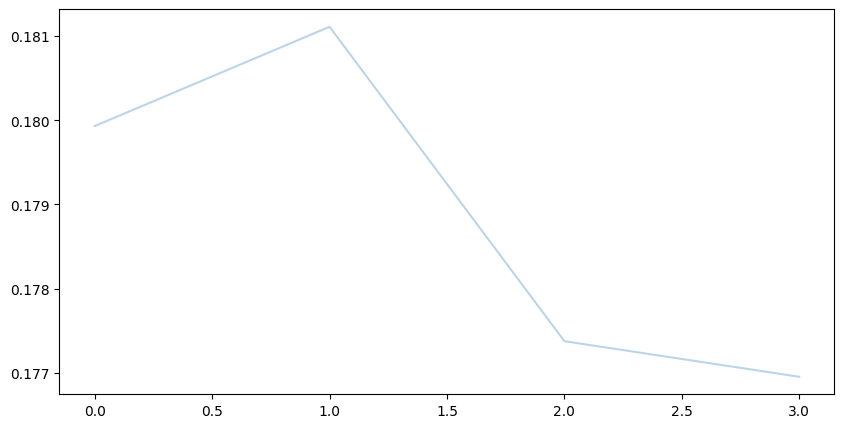

In [11]:

# Compute moving average (window size = 10)
window_size = 10
smoothed_losses = np.convolve(batch_losses, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(batch_losses, alpha=0.3, label="Raw Loss")  # Light color for raw loss
plt.plot(range(window_size - 1, len(batch_losses)), smoothed_losses, color='red', label="Smoothed Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss per Batch (Smoothed)")
plt.legend()
plt.grid()
plt.show()

# Fine-Tuned MedSAM Evaluation

### Load Model

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("flaviagiammarino/medsam-vit-base")
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("Models\medsam_vit_b_object_masks.pth")) 

# set the device to cuda
device = "cuda"
my_model.to(device)
     

KeyboardInterrupt: 

### Box Prompt Inference Demo

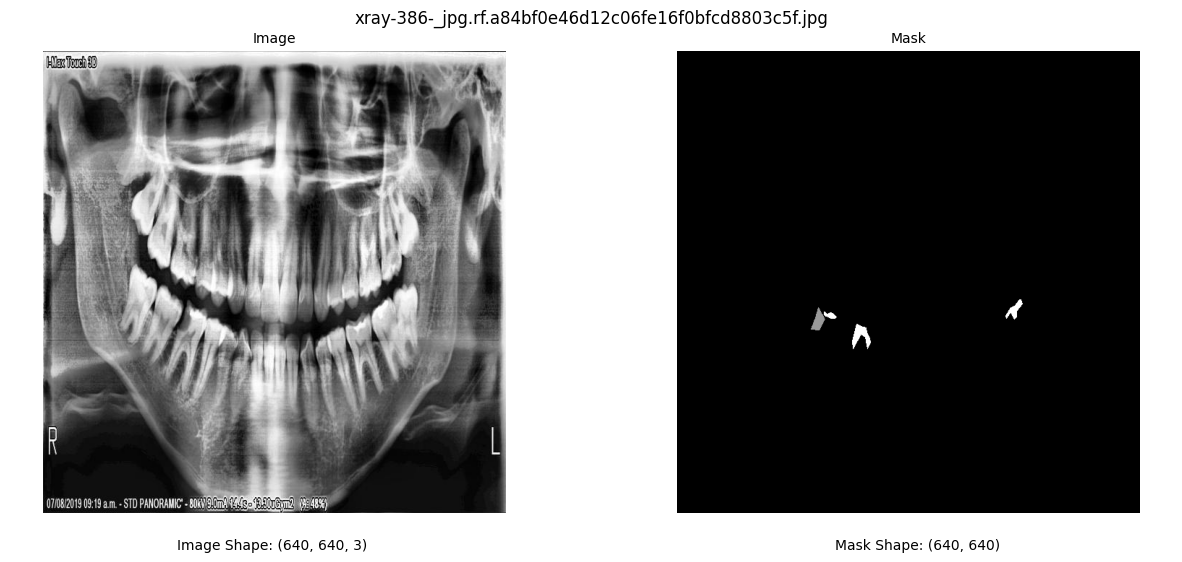

AttributeError: 'SamModel' object has no attribute 'image_encoder'

In [29]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline
test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(my_model)
bbox_prompt_demo.show(image)


### Test Inference

In [ ]:
%matplotlib inline

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [ ]:

importlib.reload(model_evaluator)
evaluator = ModelEvaluator(my_model, processor, test_dataset)


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True
test_dataset.resize_mask = False

# Load random image
#image_idx = random.randint(0, len(test_dataset)-1)

image_idx = 33

# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape

# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = my_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = evaluator.medsam_inference(image_embedding, box_np, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


if len(seg_masks.shape) == 2:
    seg_masks = [seg_masks]


# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1]) # random_colour = True
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

In [ ]:
# Verify batch item sizes
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")




print("Example Input:\n")

# Get image from batch
image = batch["pixel_values"][0].detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC format

print(image.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)  # Show the image

# Plot predicted boxes
for box in batch["input_boxes"][0]:
    rect = patches.Rectangle(
        (box[0], box[1]),  # x, y (top-left corner)
        box[2] - box[0],  # width
        box[3] - box[1],  # height
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        label='Predicted Box'
    )
    ax.add_patch(rect)

    


ax.set_title(f"Test Inference")
plt.show()



### MedSAM Fine-Tuned Model Evaluation

In [ ]:
# Evaluator defined above !!!
results = evaluator.evaluate_medsam_model()
evaluator.print_results()